In [43]:
# imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import datetime

# matplotlib config
%matplotlib inline
plt.rcParams['figure.figsize'] = (40, 20)

In [40]:
# load data
load_csv = pd.read_csv('../combined_data/sydney_sales_combined_geocoded.csv')
df = load_csv.sample(frac=0.1)
print df.iloc[1]

Unnamed: 0                                                          2513
Unnamed: 0_x                                                        2711
ADDRESS                         135/804 BOURKE STREET, WATERLOO NSW 2017
SALE PRICE                                                        660000
SALE DATE                                                     2016-09-09
AREA                                                                   0
STRATA/NON STRATA                                                 STRATA
MULTI-PROPERTY SALE (Y/N)                                             No
PROPERTY NUMBER                                                  2889801
DEALING NUMBER                                                  AK748642
EXTRACTION DATE                                            30 April 2017
SUBURB                                                          Waterloo
SALE DAY                                                               9
SALE MONTH                                         

In [29]:
# create subsets

# strata vs non-strata
strata_list = df["STRATA/NON STRATA"]
strata_series = pd.Series(strata_list)
non_strata_pattern = ["NON STRATA" in x for x in strata_series]
strata_pattern = ["STRATA" in x for x in strata_series]

df_non_strata = df["SALE PRICE"][non_strata_pattern]
df_strata = df["SALE PRICE"][strata_pattern]

In [46]:
def get_weekday(x):
    d = x['SALE DAY']
    m = x['SALE MONTH']
    y = x['SALE YEAR']
    return datetime.date(y, m, d).weekday()

df['WEEKDAY'] = df.apply(get_weekday, axis=1)

,Unnamed: 0,Unnamed: 0_x,ADDRESS,SALE PRICE,SALE DATE,AREA,STRATA/NON STRATA,MULTI-PROPERTY SALE (Y/N),PROPERTY NUMBER,DEALING NUMBER,...,lat,lng,location_type,street_name,street_number,view NE lat,view NE lng,view SW lat,view SW lng,WEEKDAY
11215,11215,12711,"410/1 DUNNING AVENUE, ROSEBERY NSW 2018",965000,2016-04-01,0.0,STRATA,No,3922253,AK417881,...,-33.910758,151.204769,ROOFTOP,Dunning Ave,1,-33.909409,151.206118,-33.912107,151.20342,4


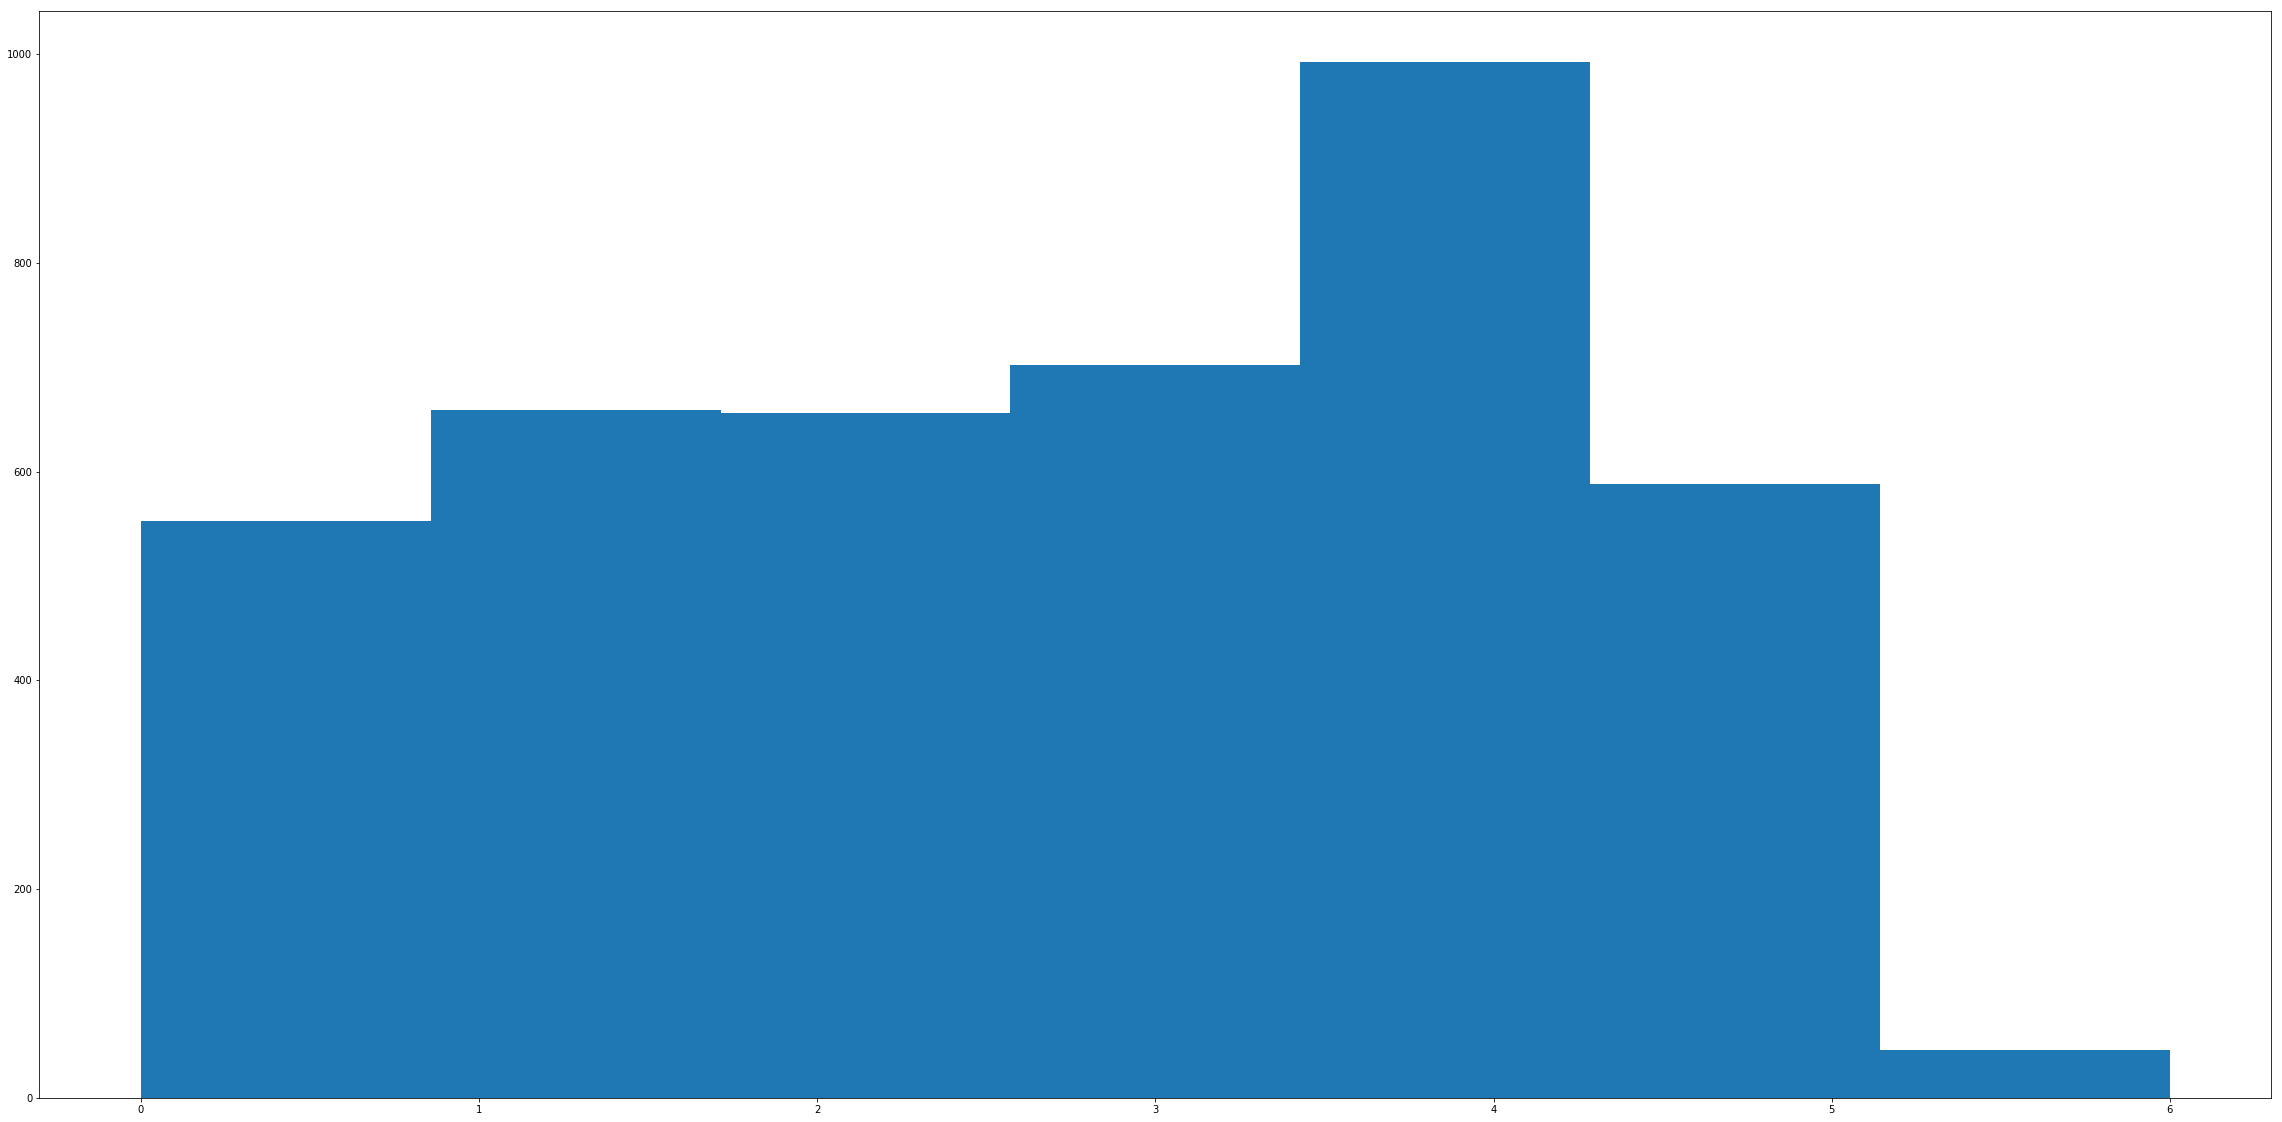

In [49]:
plt.hist(df["WEEKDAY"], bins=7);

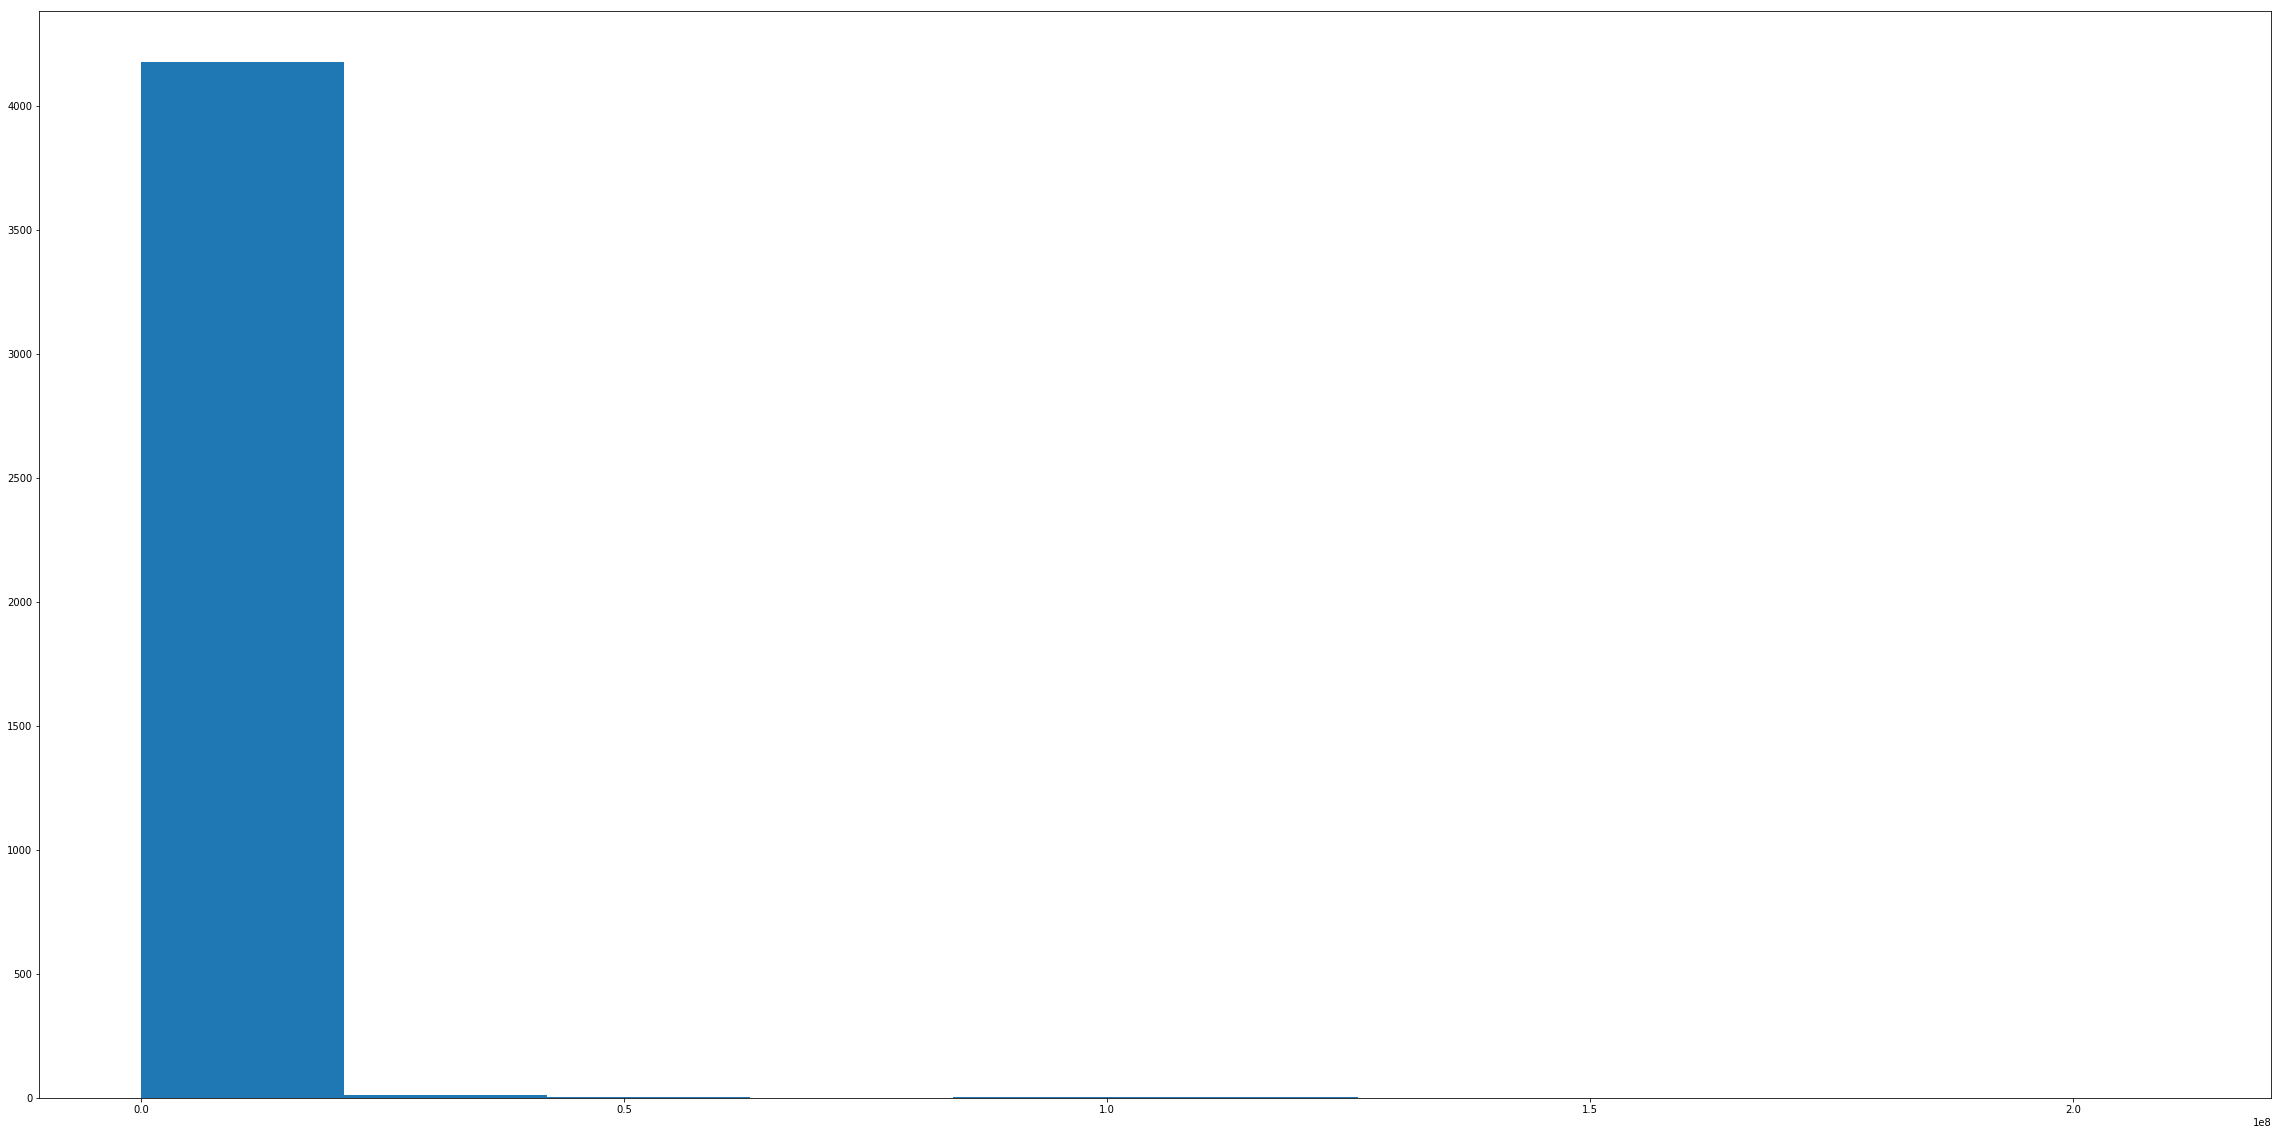

In [36]:
plt.hist(df['SALE PRICE'])
plt.show()

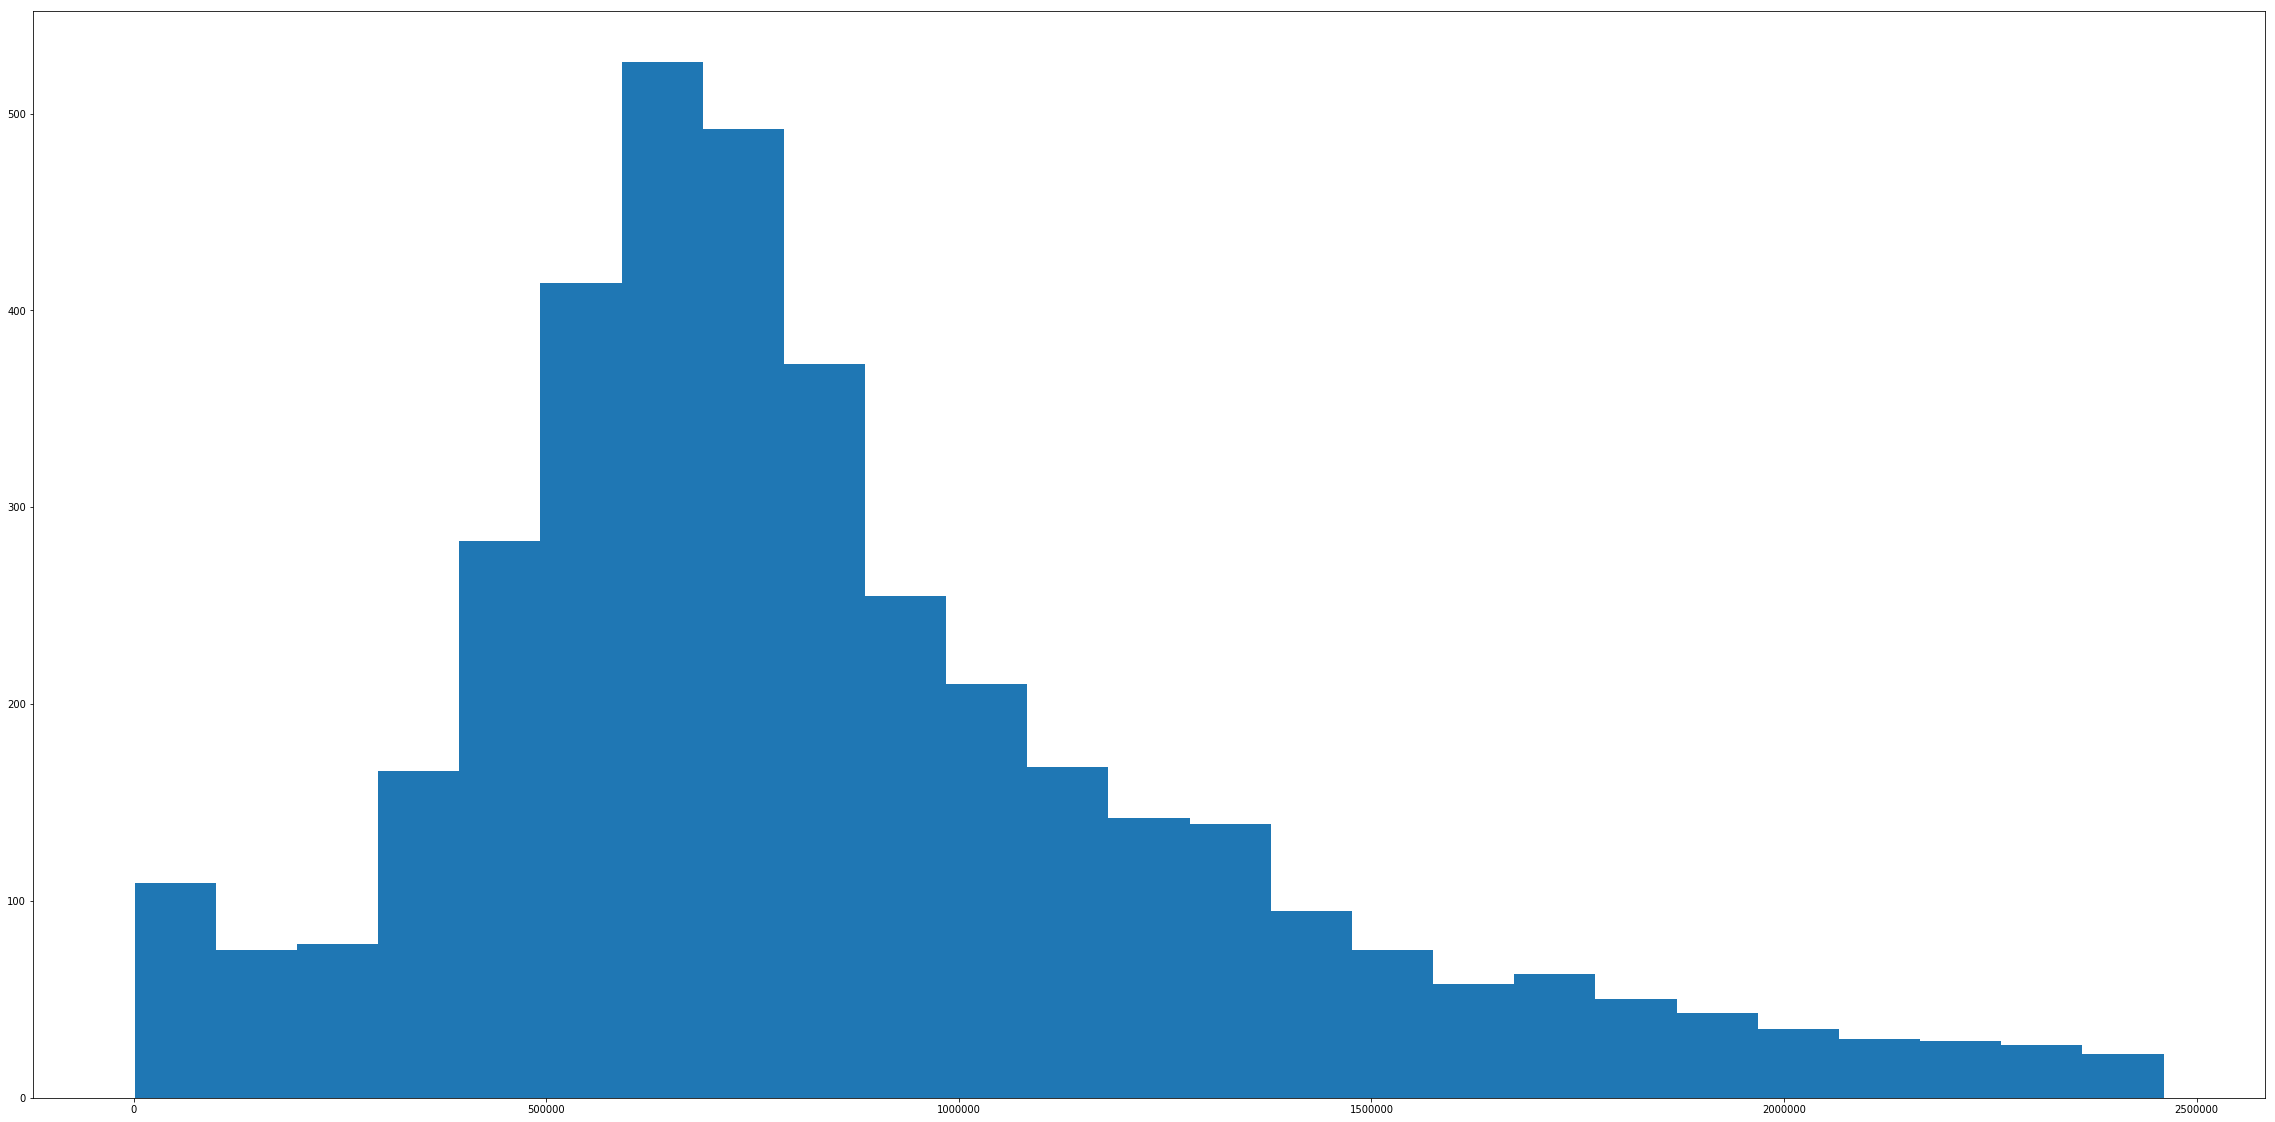

In [37]:
plt.hist(df['SALE PRICE'][df["SALE PRICE"] < 2500000], bins=25)
plt.show()

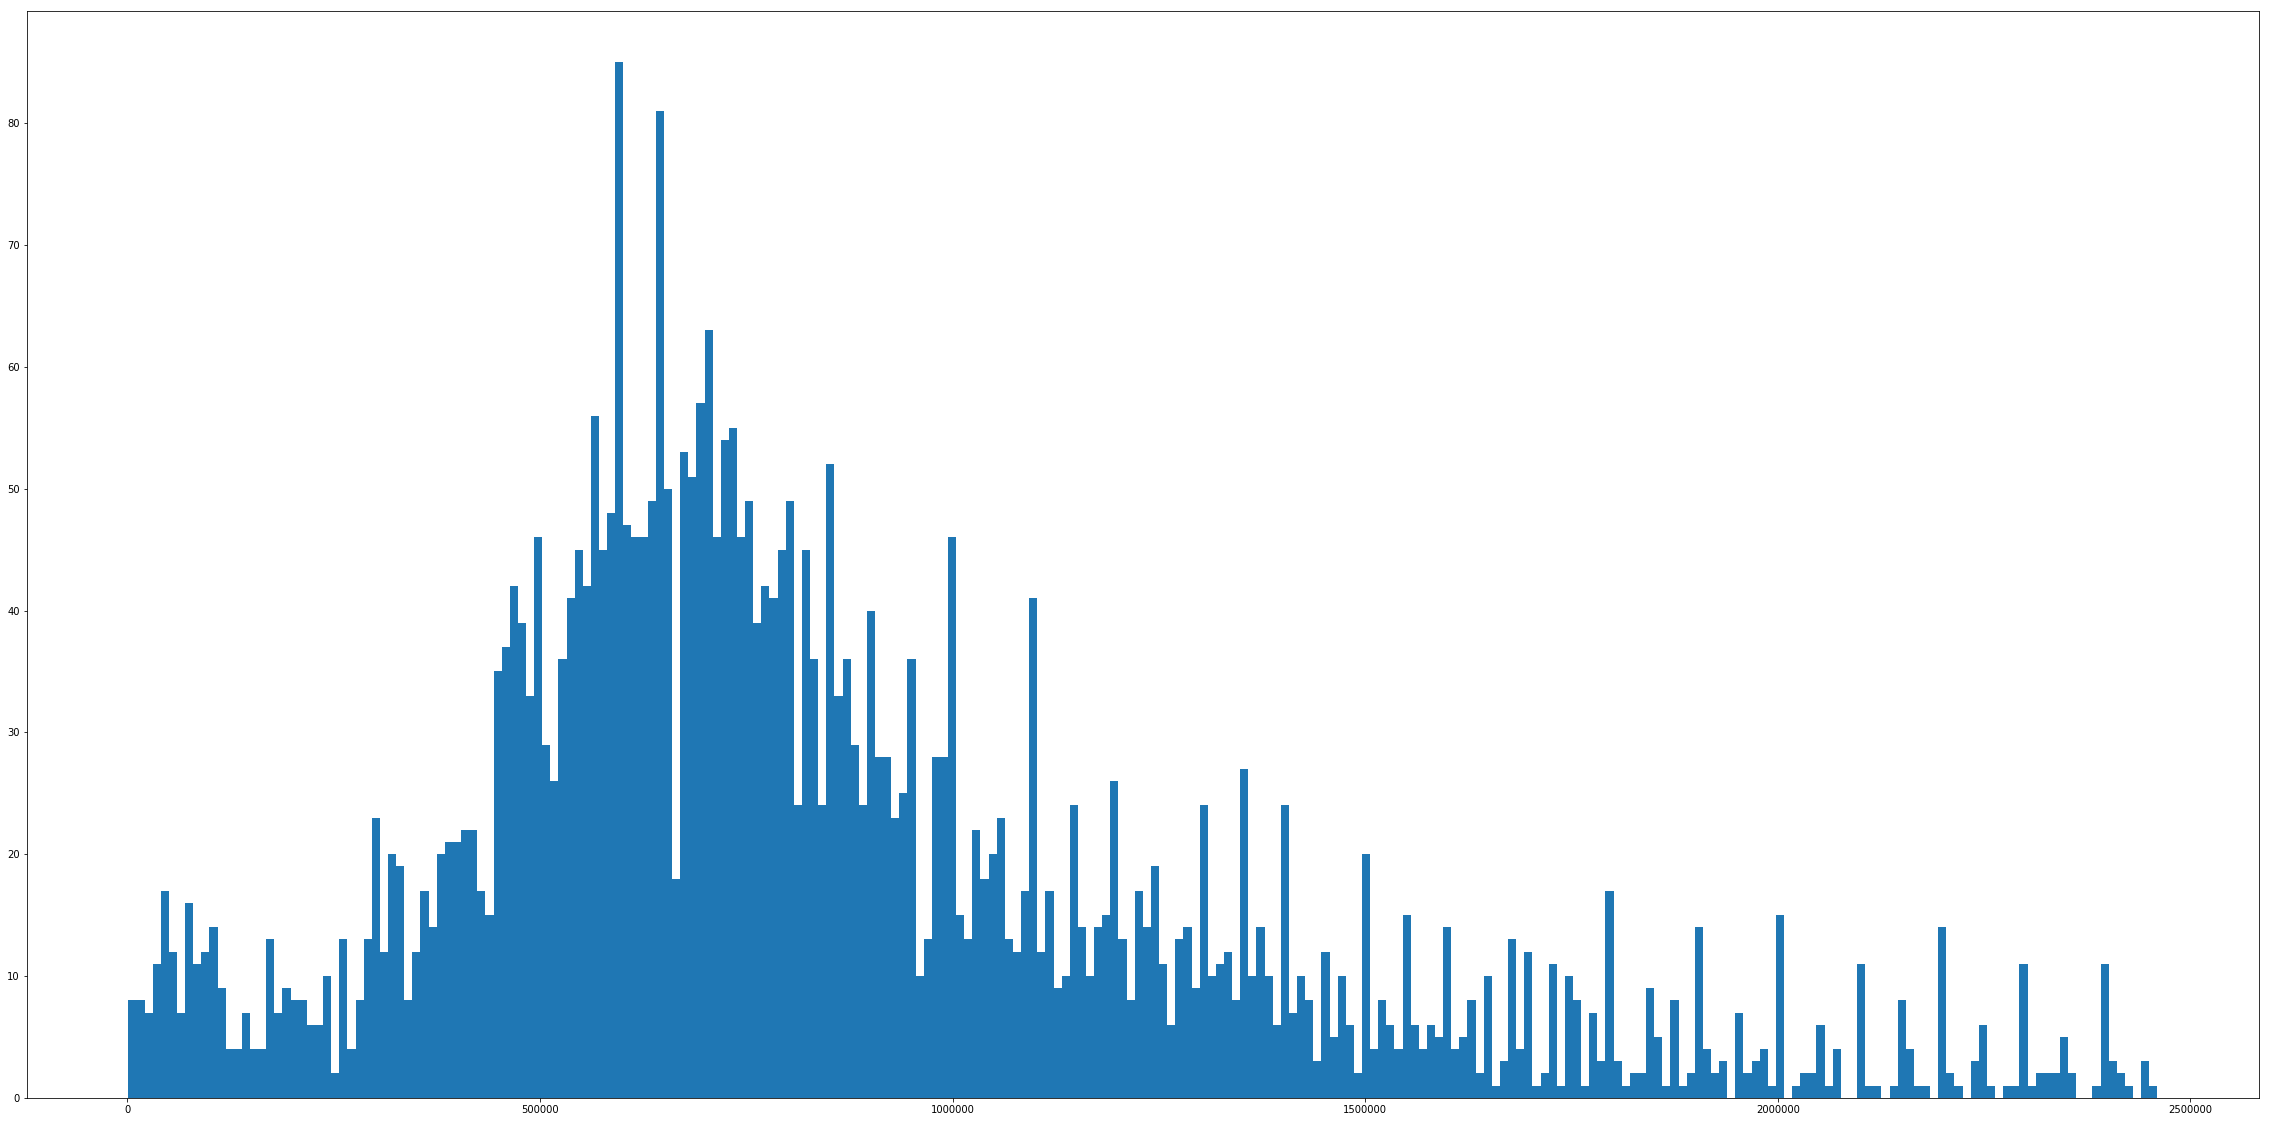

In [38]:
plt.hist(df['SALE PRICE'][df["SALE PRICE"] < 2500000], bins=250)
plt.show()

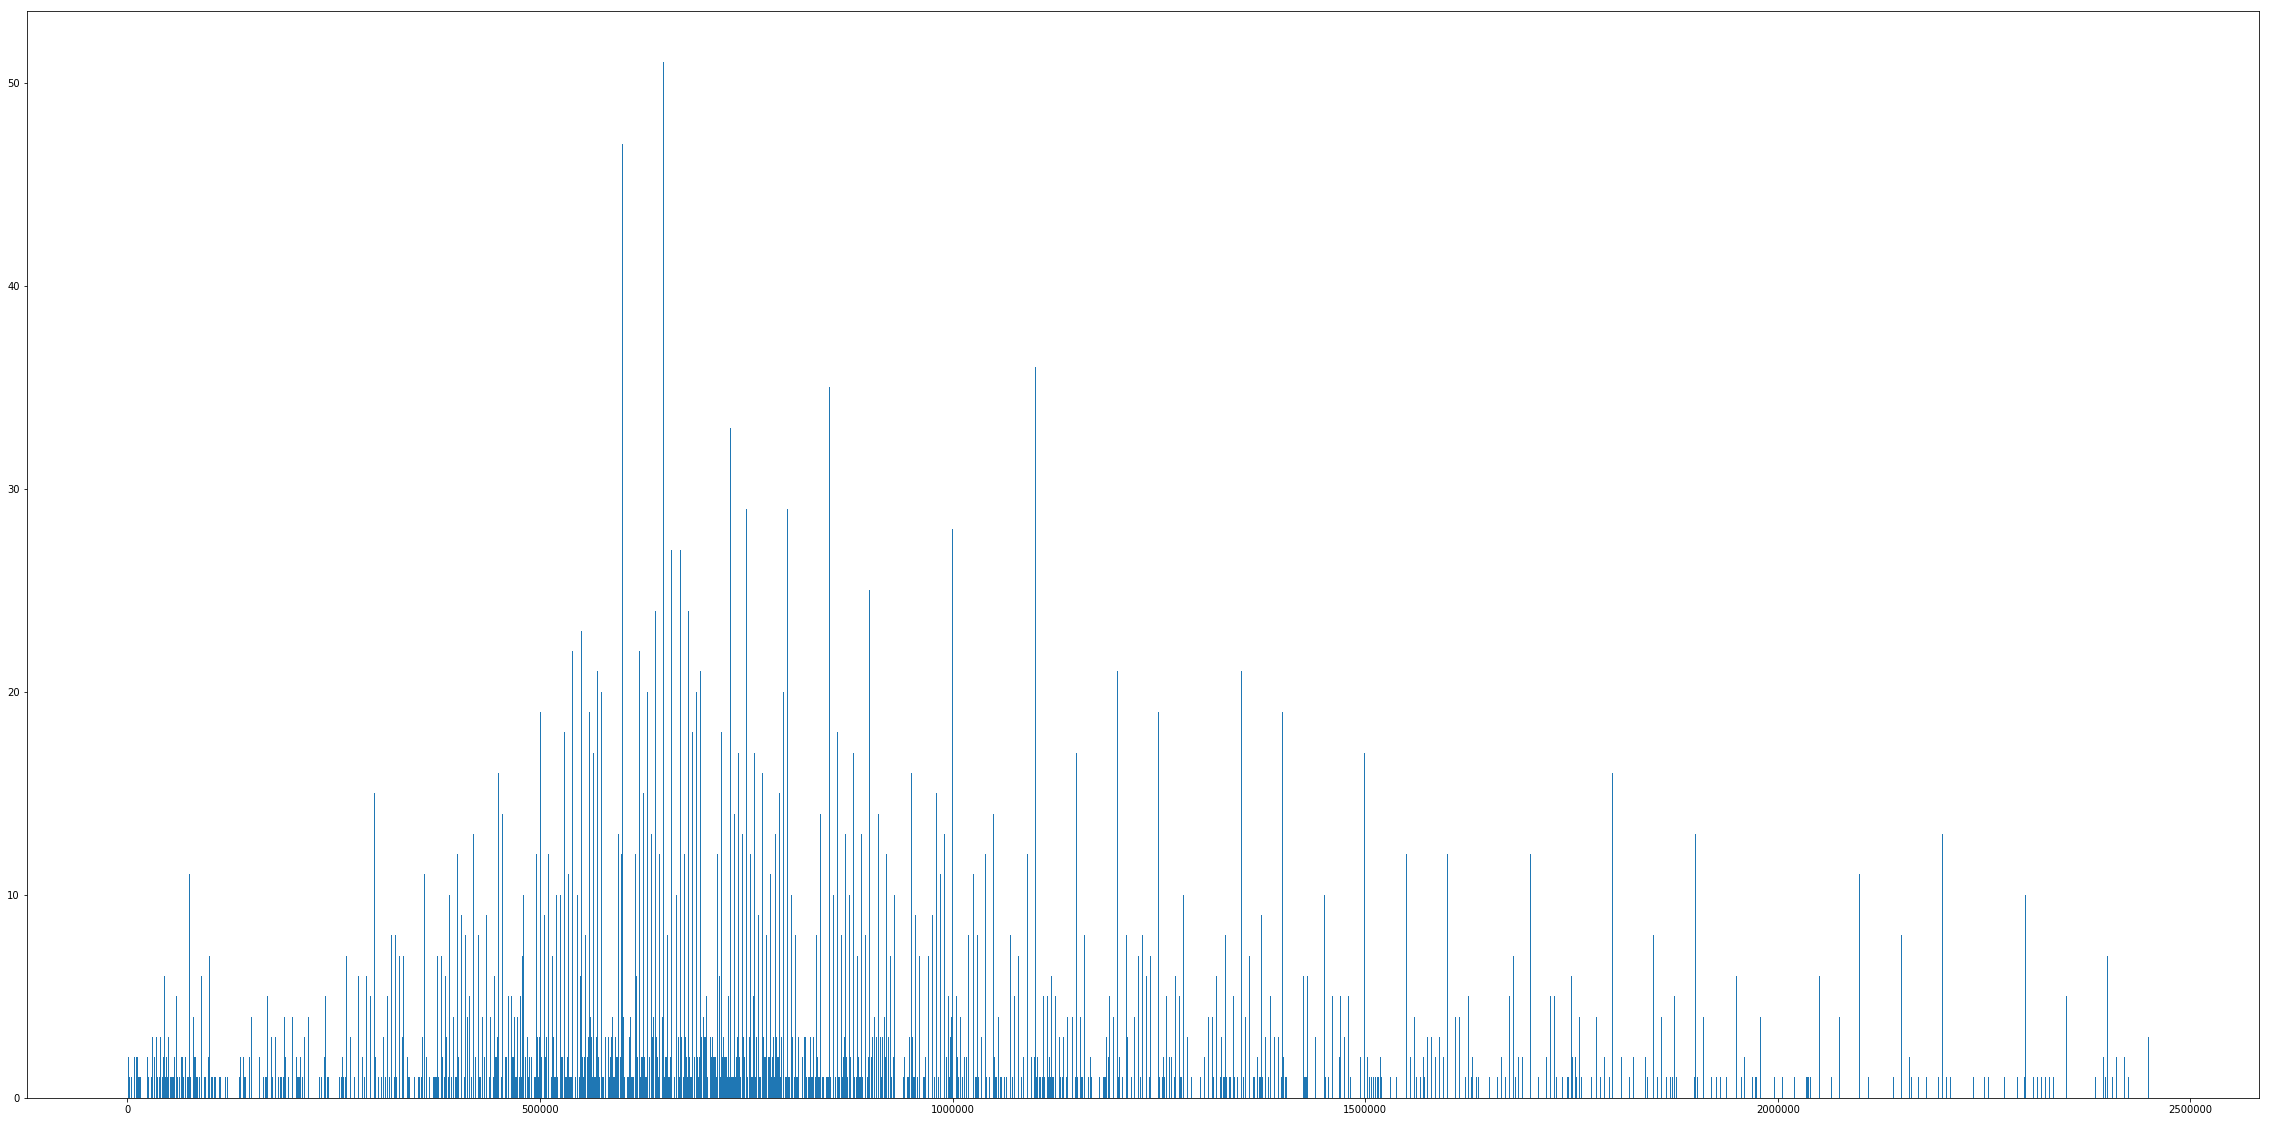

In [35]:
plt.hist(df['SALE PRICE'][df["SALE PRICE"] < 2500000], bins=2500)
plt.show()